In [38]:
import time
import numpy as np
import pandas as pd
import datetime
import urllib.request
from utils import create_null_logger
from joblib import Memory
from gmo import GmoFetcher
import matplotlib.pyplot as plt
import japanize_matplotlib
import talib

pd.set_option('display.max.columns',None)

In [8]:
memory = Memory('/tmp/gmo_fetcher_cache',verbose=0)
fetcher = GmoFetcher(memory=memory)
df = fetcher.fetch_ohlcv(market='BTC_JPY',interval_sec= 15 * 60)

In [12]:
df.to_csv('data.csv')

In [6]:
df = pd.read_csv('data.csv',index_col='timestamp')
df

,op,hi,lo,cl,volume
timestamp,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77
...,...,...,...,...,...
2023-11-30 19:45:00+00:00,5592100.0,5596273.0,5589865.0,5593859.0,2.65
2023-11-30 20:00:00+00:00,5593858.0,5594420.0,5587952.0,5592868.0,4.69
2023-11-30 20:15:00+00:00,5592381.0,5594978.0,5585067.0,5585242.0,1.90


In [7]:
df['timestamp'] = pd.to_datetime(df.index)
df['fee'] = df['timestamp'].map(lambda x: 0 if x <= pd.to_datetime('2020/08/05 06:00:00Z') else
                                          -0.00035 if x <= pd.to_datetime('2020/09/09 06:00:00Z') else
                                          -0.00025 if x <= pd.to_datetime('2020/11/04 06:00:00Z') else 0)

KeyboardInterrupt: 

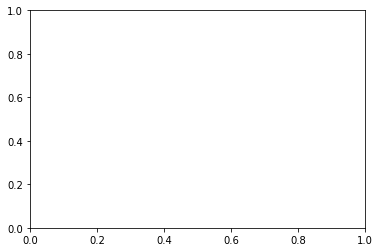

In [10]:
plt.plot(df['fee'])
plt.title('maker fee transition')
plt.show()

In [9]:
df

,op,hi,lo,cl,volume,timestamp,fee
timestamp,,,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01,2018-09-05 08:00:00+00:00,0.0
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01,2018-09-05 08:15:00+00:00,0.0
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03,2018-09-05 08:45:00+00:00,0.0
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22,2018-09-05 09:00:00+00:00,0.0
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77,2018-09-05 09:15:00+00:00,0.0
...,...,...,...,...,...,...,...
2023-11-30 19:45:00+00:00,5592100.0,5596273.0,5589865.0,5593859.0,2.65,2023-11-30 19:45:00+00:00,0.0
2023-11-30 20:00:00+00:00,5593858.0,5594420.0,5587952.0,5592868.0,4.69,2023-11-30 20:00:00+00:00,0.0
2023-11-30 20:15:00+00:00,5592381.0,5594978.0,5585067.0,5585242.0,1.90,2023-11-30 20:15:00+00:00,0.0


In [19]:
# 特徴量作成
# 例としてtalibで特徴量をいくつか生成
def calc_features(df):
   open = df['op']
   high = df['hi']
   low = df['lo']
   close = df['cl']
   volume = df['volume']
   
   orig_columns = df.columns
   print('calc talib overlap')
   hilo = (df['hi'] + df['lo']) / 2
   df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
   df['BBANDS_upperband'] -= hilo
   df['BBANDS_middleband'] -= hilo
   df['BBANDS_lowerband'] -= hilo
   df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
   df['EMA'] = talib.EMA(close,timeperiod=30) - hilo
   df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
   df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
   df['MA'] = talib.MA(close,timeperiod=30,matype=0) - hilo
   df['MIDPOINT'] = talib.MIDPOINT(close,timeperiod=14) - hilo
   df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
   df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
   df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
   df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
   df['WMA'] = talib.WMA(close, timeperiod=30) - hilo
   df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
   df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
   df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
   df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
   df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
   df['BOP'] = talib.BOP(open, high, low, close)
   df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
   df['DX'] = talib.DX(high, low, close, timeperiod=14)
   df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
   df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
   df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
   df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
   df['MOM'] = talib.MOM(close, timeperiod=10)
   df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
   df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
   df['RSI'] = talib.RSI(close, timeperiod=14)
   df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
   df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
   df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
   df['TRIX'] = talib.TRIX(close, timeperiod=30)
   df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
   df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
   df['AD'] = talib.AD(high, low, close, volume)
   df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
   df['OBV'] = talib.OBV(close, volume)
   df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
   df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
   df['TRANGE'] = talib.TRANGE(high, low, close)
   df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
   df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
   df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
   df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
   df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)
   df['BETA'] = talib.BETA(high, low, timeperiod=5)
   df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
   df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
   df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
   df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
   df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
   df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)
   
   return df

In [32]:
df = calc_features(df)
df

calc talib overlap


,op,hi,lo,cl,volume,timestamp,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,buy_price,sell_price,buy_fep,buy_fet,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01,2018-09-05 08:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,818723.0,818725.0,821249.0,1.0,818725.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01,2018-09-05 08:15:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.02,NaN,NaN,2526.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,821249.0,821251.0,821249.0,1.0,819766.0,2.0,1.0,1.0,-0.001806,0.001808,-0.000001
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03,2018-09-05 08:45:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030000,NaN,-0.01,NaN,NaN,1990.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819764.0,819766.0,819764.0,2.0,819766.0,2.0,1.0,0.0,-0.000265,0.000000,-0.000001
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22,2018-09-05 09:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.240466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.130551,NaN,-1.23,NaN,NaN,1888.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819545.0,819547.0,820243.0,4.0,819547.0,3.0,0.0,0.0,0.000000,0.000000,0.000000
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77,2018-09-05 09:15:00+00:00,0.0,983.257246,-682.2,-2347.657246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.104565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.524266,NaN,13.54,NaN,NaN,1984.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,832.728623,820243.0,820245.0,820243.0,4.0,820245.0,4.0,1.0,0.0,-0.031452,0.000000,-0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30 19:45:00+00:00,5592100.0,5596273.0,5589865.0,5593859.0,2.65,2023-11-30 19:45:00+00:00,0.0,5573.307753,-4238.6,-14050.507753,-8463.537447,-12060.859940,-15370.813439,-9712.086004,-13170.900000,-13318.0,-13170.900000,-8975.889917,-5374.736615,-17751.841667,-12424.129032,14.887825,19.953257,5600.025641,7.142857,92.857143,85.714286,0.274501,97.962338,9.255549,3926.895533,2044.805360,1882.090173,73.753041,19.160233,29423.616422,19305.0,23.068758,35425.784193,58.125818,76.450184,61.517114,77.652934,76.450184,100.000000,91.099819,0.000629,59.124942,-11.330493,266272.005172,1.476012,10252.50,10969.004799,0.196090,6408.0,21.591415,149.073657,9332

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


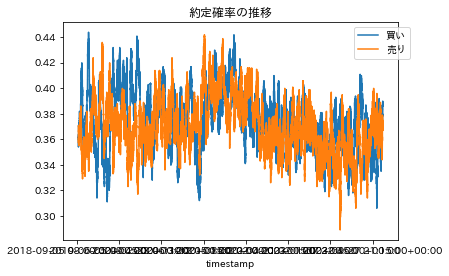

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


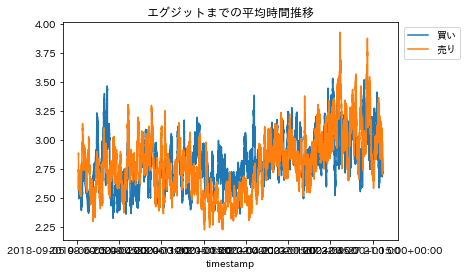

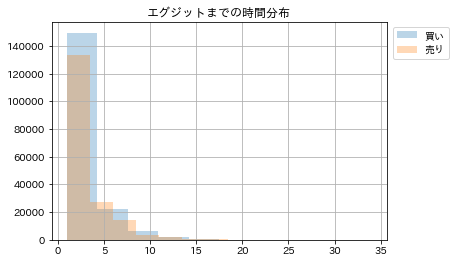

毎時刻、この執行方法でトレードした場合の累積リターン


/Users/apple/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


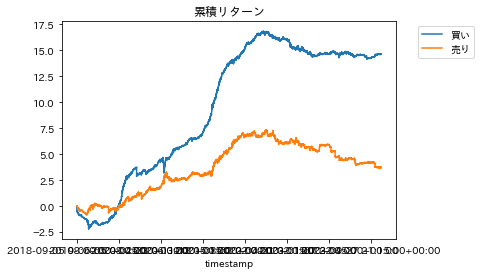

In [44]:
#@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

In [45]:
df

,op,hi,lo,cl,volume,timestamp,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,buy_price,sell_price,buy_fep,buy_fet,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01,2018-09-05 08:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,818723.0,818725.0,821249.0,2.0,818725.0,1.0,0.0,1.0,0.000000,-0.003083,0.000000,-0.000001
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01,2018-09-05 08:15:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.02,NaN,NaN,2526.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,821249.0,821251.0,821249.0,1.0,819766.0,2.0,1.0,0.0,-0.001806,0.000000,-0.000001,0.000000
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03,2018-09-05 08:45:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030000,NaN,-0.01,NaN,NaN,1990.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819764.0,819766.0,819764.0,1.0,819766.0,1.0,1.0,1.0,-0.000265,-0.000582,-0.000001,-0.000001
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22,2018-09-05 09:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.240466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.130551,NaN,-1.23,NaN,NaN,1888.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819545.0,819547.0,820243.0,2.0,819547.0,1.0,0.0,1.0,0.000000,-0.000849,0.000000,-0.000001
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77,2018-09-05 09:15:00+00:00,0.0,983.257246,-682.2,-2347.657246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.104565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.524266,NaN,13.54,NaN,NaN,1984.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,832.728623,820243.0,820245.0,820243.0,1.0,820245.0,1.0,1.0,1.0,-0.031452,0.000909,-0.000001,-0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30 19:45:00+00:00,5592100.0,5596273.0,5589865.0,5593859.0,2.65,2023-11-30 19:45:00+00:00,0.0,5573.307753,-4238.6,-14050.507753,-8463.537447,-12060.859940,-15370.813439,-9712.086004,-13170.900000,-13318.0,-13170.900000,-8975.889917,-5374.736615,-17751.841667,-12424.129032,14.887825,19.953257,5600.025641,7.142857,92.857143,85.714286,0.274501,97.962338,9.255549,3926.895533,2044.805360,1882.090173,73.753041,19.160233,29423.616422,19305.0,23.068758,35425.784193,58.125818,76.450184,61.517114,77.652934,76.450184,100.000000,91.099819,0.000629,59.124942,-11.330493,266272.005172,1.476

In [46]:
df

,op,hi,lo,cl,volume,timestamp,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,EMA,HT_TRENDLINE,KAMA,MA,MIDPOINT,SMA,T3,TEMA,TRIMA,WMA,ADX,ADXR,APO,AROON_aroondown,AROON_aroonup,AROONOSC,BOP,CCI,DX,MACD_macd,MACD_macdsignal,MACD_macdhist,MFI,MINUS_DI,MINUS_DM,MOM,PLUS_DI,PLUS_DM,RSI,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,TRIX,ULTOSC,WILLR,AD,ADOSC,OBV,ATR,NATR,TRANGE,HT_DCPERIOD,HT_DCPHASE,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV,buy_price,sell_price,buy_fep,buy_fet,sell_fep,sell_fet,buy_executed,sell_executed,y_buy,y_sell,buy_cost,sell_cost
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01,2018-09-05 08:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,818723.0,818725.0,821249.0,2.0,818725.0,1.0,0.0,1.0,0.000000,-0.003083,0.000000,-0.000001
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01,2018-09-05 08:15:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.02,NaN,NaN,2526.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,821249.0,821251.0,821249.0,1.0,819766.0,2.0,1.0,0.0,-0.001806,0.000000,-0.000001,0.000000
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03,2018-09-05 08:45:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.030000,NaN,-0.01,NaN,NaN,1990.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819764.0,819766.0,819764.0,1.0,819766.0,1.0,1.0,1.0,-0.000265,-0.000582,-0.000001,-0.000001
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22,2018-09-05 09:00:00+00:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.240466,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.130551,NaN,-1.23,NaN,NaN,1888.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,819545.0,819547.0,820243.0,2.0,819547.0,1.0,0.0,1.0,0.000000,-0.000849,0.000000,-0.000001
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77,2018-09-05 09:15:00+00:00,0.0,983.257246,-682.2,-2347.657246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.104565,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.524266,NaN,13.54,NaN,NaN,1984.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,832.728623,820243.0,820245.0,820243.0,1.0,820245.0,1.0,1.0,1.0,-0.031452,0.000909,-0.000001,-0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-30 19:45:00+00:00,5592100.0,5596273.0,5589865.0,5593859.0,2.65,2023-11-30 19:45:00+00:00,0.0,5573.307753,-4238.6,-14050.507753,-8463.537447,-12060.859940,-15370.813439,-9712.086004,-13170.900000,-13318.0,-13170.900000,-8975.889917,-5374.736615,-17751.841667,-12424.129032,14.887825,19.953257,5600.025641,7.142857,92.857143,85.714286,0.274501,97.962338,9.255549,3926.895533,2044.805360,1882.090173,73.753041,19.160233,29423.616422,19305.0,23.068758,35425.784193,58.125818,76.450184,61.517114,77.652934,76.450184,100.000000,91.099819,0.000629,59.124942,-11.330493,266272.005172,1.476